In [1]:
## Load environment variables

import os
from dotenv import load_dotenv, find_dotenv, dotenv_values

# Load with explicit path and allow override
dotenv_path = find_dotenv(usecwd=True)
print("dotenv_path:", dotenv_path or "NOT FOUND")
load_dotenv(dotenv_path=dotenv_path, override=True)

# Show what was parsed from the file (safe preview)
parsed = dotenv_values(dotenv_path) if dotenv_path else {}
print("Keys in .env:", sorted(parsed.keys()))
print("Has OPENAI_API_KEY in .env?:", "OPENAI_API_KEY" in parsed)

val = os.getenv("OPENAI_API_KEY")
print("Env OPENAI_API_KEY present?:", val is not None)
print("Value prefix (masked):", (val[:6] + "…") if val else None)

# Current working directory (to catch path mistakes)
print("cwd:", os.getcwd())

dotenv_path: /Users/anupam/Documents/Programming/rag101/.env
Keys in .env: ['LANGSMITH_API_KEY', 'LANGSMITH_ENDPOINT', 'LANGSMITH_PROJECT', 'LANGSMITH_TRACING', 'OPENAI_API_KEY']
Has OPENAI_API_KEY in .env?: True
Env OPENAI_API_KEY present?: True
Value prefix (masked): sk-pro…
cwd: /Users/anupam/Documents/Programming/rag101


In [2]:
# Define LLM model

import getpass, os
from langchain.chat_models import init_chat_model

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

llm = init_chat_model("gpt-4o-mini", model_provider="openai")


In [3]:
# Choose embeddings

import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
# Chose vector store

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

print(f"Total characters: {len(docs[0].page_content)}")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)

print("Document Ids:", document_ids[:5])

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047
Split blog post into 63 sub-documents.
Document Ids: ['027624bf-c5e7-433b-89ee-3f12f4054a02', '5a0529f3-86ac-4834-a948-762adbd5d079', '013d5471-2c84-4c17-a5f9-607a6aa89662', '74fba01a-bf12-4aff-8e07-d643898382ac', 'e2d74242-6d50-469f-ae80-ce661c53a72e']


In [10]:
response = graph.invoke({"question": "What car should I buy?"})
print(response["answer"])

I don't know.


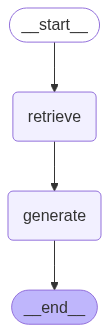

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# A peek under the hood 

result = graph.invoke({"question": "What is the taste of an orange?"})

print(f"Context: {result['context']}\n\n")
print(result["answer"])

Context: [Document(id='ea0302c4-83ec-4a0a-87a2-2f8ef59fdfff', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 10685}, page_content='Short-Term Memory (STM) or Working Memory: It stores information that we are currently aware of and needed to carry out complex cognitive tasks such as learning and reasoning. Short-term memory is believed to have the capacity of about 7 items (Miller 1956) and lasts for 20-30 seconds.\n\n\nLong-Term Memory (LTM): Long-term memory can store information for a remarkably long time, ranging from a few days to decades, with an essentially unlimited storage capacity. There are two subtypes of LTM:\n\nExplicit / declarative memory: This is memory of facts and events, and refers to those memories that can be consciously recalled, including episodic memory (events and experiences) and semantic memory (facts and concepts).\nImplicit / procedural memory: This type of memory is unconscious and involves skills and routines th

In [9]:
# Add query as additional step. To do this, we split the document into three parts - beginning, middle and end - and modify our queries to state which part needs to be referred to
from typing import Literal
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

print(f"Total characters: {len(docs[0].page_content)}")

# Split text into chunks again

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


# Define application steps
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

Total characters: 43047
Split blog post into 63 sub-documents.


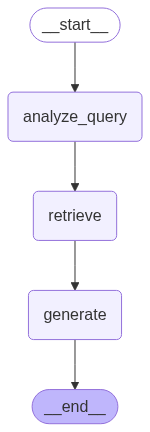

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Test with query

for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='a9028418-e5c6-48ad-8854-2d3a980b49e6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 32987, 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowe